In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import pandas as pd


classifiers = {
    'kNN': KNeighborsClassifier(n_neighbors=11),
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier()
}

def standardize(train_data, test_data):
    sc = StandardScaler()
    train_data = sc.fit_transform(train_data)
    test_data = sc.transform(test_data)
    return train_data, test_data

def load_data_to_df():
    file_path_data = "CATSnDOGS.csv"
    file_path_labels = "Labels.csv"
    delimiter = ","
    df_data = pd.read_csv(file_path_data, delimiter=delimiter, header=0, quotechar='"')
    df_labels = pd.read_csv(
        file_path_labels, delimiter=delimiter, header=0, quotechar='"'
    )
    images = df_data.to_numpy()
    correct_images = [im.reshape(64, 64).T for im in images]
    correct_images = np.array(correct_images)
    flattened_correct_images = [im.flatten() for im in correct_images]
    df = pd.DataFrame(flattened_correct_images)
    df["Label"] = df_labels
    
    return df

def rotate_images(df):
    indices_to_rotate = np.random.choice(df.index, len(df) // 2, replace=False)
   # Work only with the image data (assuming 'Label' is the last column)
    image_data = df.drop('Label', axis=1)
    images = image_data.to_numpy()
       # Rotate selected images by 180 degrees
    for index in indices_to_rotate:
        images[index] = np.rot90(images[index].reshape(64, 64), 2).flatten()  # Rotate and flatten the image


    # Reconstruct the DataFrame
    rotated_df = pd.DataFrame(images, columns=df.columns[:-1])
    rotated_df['Label'] = df['Label']  # Reattach the label
    return rotated_df


### Comment: 
#Clearly the classification drops in performance ove tests with rotated images.
#This is expected as the model has not been trained on rotated images.



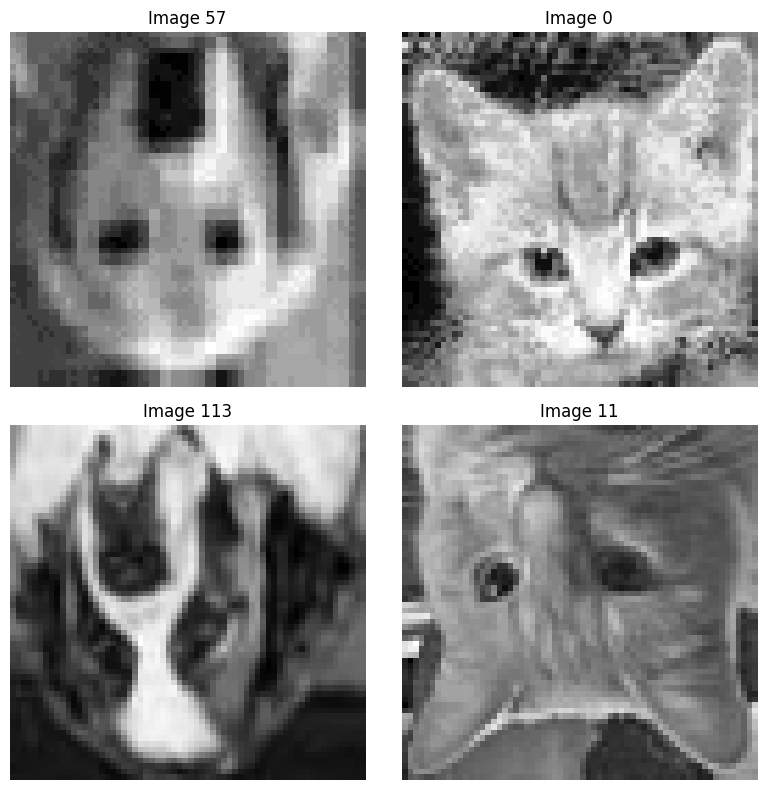

In [3]:
#Just loading and rotating images.
# Load and rotate images
df = load_data_to_df()
df = rotate_images(df)
# Sample four random images from the DataFrame
sampled_images = df.sample(4)

# Set up the figure and axes for a 2x2 grid of images
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axes = axes.ravel()  # Flatten the array of axes

# Loop over the randomly sampled images and plot each one
for i, (idx, row) in enumerate(sampled_images.iterrows()):
    image = row.drop('Label').values.reshape(64, 64) 
    axes[i].imshow(image, cmap='gray')  
    axes[i].set_title(f"Image {idx}") 
    axes[i].axis('off')  

plt.tight_layout()
plt.show()  


In [6]:
#Train on rotated images
X = df.drop('Label', axis=1).values  # Feature set
y = df['Label'].values  # Labels
results_rotated = {}
for _ in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train_scaled, X_test_scaled = standardize(X_train, X_test)   #Mind: no 


    for name, clf in classifiers.items():
        clf.fit(X_train_scaled, y_train.ravel())
        y_pred = clf.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        if name not in results_rotated.keys():
            results_rotated[name] = []
        results_rotated[name].append(accuracy)

        cross_val_acc = cross_val_score(clf, X, y, cv=5)  # 5-fold cross-validation
        #print(f"{name} test accuracy: {accuracy:.2f}, Cross-validated accuracy: {np.mean(cross_val_acc):.2f}")

#Train on non-rotated images
df = load_data_to_df()
X = df.drop('Label', axis=1).values  # Feature set
y = df['Label'].values  # Labels
results = {}
for _ in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train_scaled, X_test_scaled = standardize(X_train, X_test)   #Mind: no

    for name,clf in classifiers.items():
        clf.fit(X_train_scaled, y_train.ravel())
        y_pred = clf.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        if name not in results.keys():
            results[name] = []
        results[name].append(accuracy)

        cross_val_acc = cross_val_score(clf, X, y, cv=5)
        #print(f"{name} test accuracy: {accuracy:.2f}, Cross-validated accuracy: {np.mean(cross_val_acc):.2f}")

# Create DataFrame for box plot non-rotated
df = pd.DataFrame(results.items(), columns=['Classifier', 'Accuracy'])
#Create DataFrame for box plot rotated
df_rotated = pd.DataFrame(results_rotated.items(), columns=['Classifier', 'Accuracy'])

# Plotting
plt.figure(figsize=(10, 6))
plt.boxplot(df['Accuracy'], patch_artist=True)
plt.boxplot(df_rotated['Accuracy'], patch_artist=True, cmap='coolwarm')
plt.xticks([i+1 for i in range(len(df))], df['Classifier'], rotation=45, ha='right')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Classifier Comparison')
plt.legend('Medians', loc='best')
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.show()


    


KeyError: "['Label'] not found in axis"

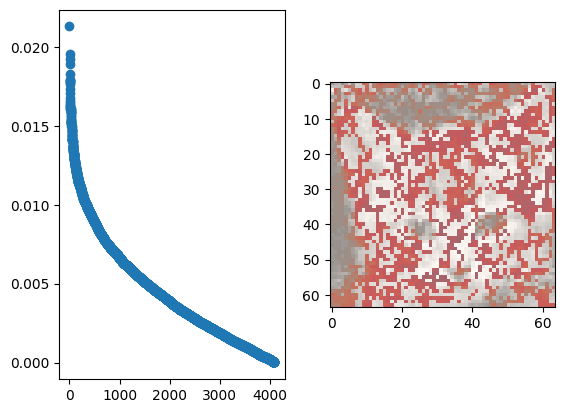

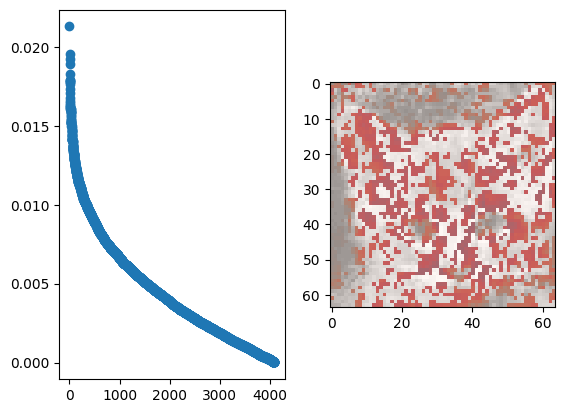

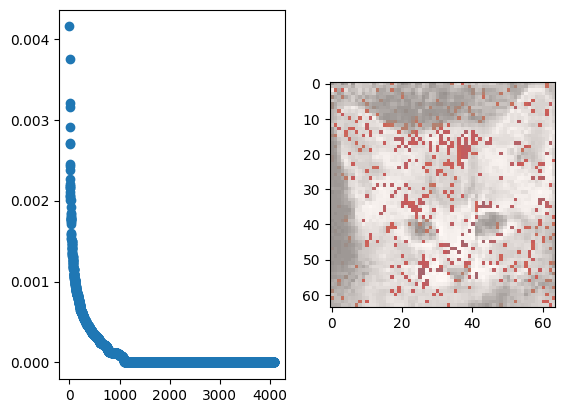

In [5]:
from sklearn.feature_selection import SelectFromModel


######### SVM ##############
svm = SVC(kernel='linear')
svm.fit(X_train_scaled, y_train.ravel())

# Identify important features using SVM coefficients
svm_coefs = svm.coef_
abs_coefs = np.abs(svm_coefs)
important_features = np.argsort(abs_coefs)[::-1]

#print("Indices of important features:", len(important_features[0]))

plt.subplot(1,2,1)
abs_coefs[0].sort()
plt.plot(abs_coefs[0][::-1], 'o')
plt.subplot(1,2,2)
image = X[0, :]
image_reduced = np.zeros_like(image)
image_reduced[important_features[0][:2000]] = image[important_features[0][:2000]]
plt.imshow(image.reshape(64, 64), cmap='gray')
plt.imshow(image_reduced.reshape(64, 64), cmap='Reds', alpha=0.6)  # Use alpha to control transparency
plt.show()

############# LR #############
lr_model = LogisticRegression(max_iter=1000)

# Fit the model
lr_model.fit(X_train_scaled, y_train.ravel())

# Use the model to select important features
feature_selector = SelectFromModel(lr_model, threshold='mean')  # Select features based on their importance
feature_selector.fit(X_train_scaled, y_train.ravel())

# Get selected features
important_features = np.where(feature_selector.get_support())[0]

plt.subplot(1,2,1)
abs_coefs[0].sort()
plt.plot(abs_coefs[0][::-1], 'o')
plt.subplot(1,2,2)
image = X[0, :]
image_reduced = np.zeros_like(image)
image_reduced[important_features] = image[important_features]
plt.imshow(image.reshape(64, 64), cmap='gray')
plt.imshow(image_reduced.reshape(64, 64), cmap='Reds', alpha=0.6)  # Use alpha to control transparency
plt.show()


############ RF ################
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train.ravel())

# Extract feature importance from tree splits
feature_importance = np.zeros(X.shape[1])
for tree in rf.estimators_:
    tree_feature_importance = tree.tree_.compute_feature_importances(normalize=False)
    feature_importance += tree_feature_importance

# Normalize feature importance across trees
feature_importance /= len(rf.estimators_)
important_features = np.argsort(feature_importance)[::-1]


plt.subplot(1,2,1)
feature_importance.sort()
plt.plot(feature_importance[::-1], 'o')
plt.subplot(1,2,2)
image = X[0, :]
image_reduced = np.zeros_like(image)
image_reduced[important_features[:500]] = image[important_features[:500]]
plt.imshow(image.reshape(64, 64), cmap='gray')
plt.imshow(image_reduced.reshape(64, 64), cmap='Reds', alpha=0.6)  # Use alpha to control transparency
plt.show()

